# Setup

In [1]:
# python modules
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
from collections import defaultdict
from matplotlib.collections import LineCollection

In [2]:
from scipy.signal import argrelmin, argrelextrema
from scipy.signal import savgol_filter
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [4]:
sns.set_style("darkgrid")
sns.set_context("paper")

In [5]:
# custom functions
import parse_threshold_results as ptr

In [6]:
base_dir = Path("..")
result_path = base_dir / "output" / "threshold-stats"

In [7]:
import design

In [8]:
def density_min(df):
    d = df["density"].min()
    t = df[df["density"] ==  d]["threshold"].min()
    return t, d
density_min.label = "density min"


def density_local_minimas(df, smoothing_window=5, minima_order=10):
    smooth_density = savgol_filter(df["density"].values, smoothing_window, 3)
    minimas = argrelextrema(smooth_density, np.less_equal, order=minima_order)[0]
    t = []
    d = []
    for x in minimas:
        t_ = df["threshold"].iloc[x]
        d_ = df["density"].iloc[x]
        t.append(t_)
        d.append(d_)
    return t, d
density_local_minimas.label = "density local minimas"

In [9]:
threshold_stats = {c:{} for c in design.contrasts}
thresholds = {}

In [10]:
def plot_and_calculate_thresholds(max_v=100, smoothing_window=5, minima_order=10):

    for contrast in design.contrasts:
        print(contrast)
        prefix = f"{contrast}"
        D, df = ptr.get_result_per_prefix(result_path, prefix)
        threshold_stats[contrast]["D"] = D
        threshold_stats[contrast]["df"] = df

    nrows =  len(design.contrasts)
    ncols = 1

    fig = plt.figure(figsize=(20, 20))
    subfigs = fig.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True)
    
    for (contrast, ax) in zip(design.contrasts, subfigs):
        ax.set_title(contrast, fontsize='large')

        D, df = threshold_stats[contrast]["D"], threshold_stats[contrast]["df"]

        ### DENSITY
        
        x = df["threshold"]
        y = df["density"]
        ax.plot(x, savgol_filter(df["density"].values, smoothing_window, 3), alpha=0.4, color='black', linewidth=4)
        ax.set_ylabel('Density')
        ax.set_xlabel('Threshold')

        z = df["vertex-count"]
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(z.min(), z.max())
        lc = LineCollection(segments, cmap='winter_r', norm=norm)
        lc.set_array(z)
        lc.set_linewidth(2)
        line = ax.add_collection(lc)
        fig.colorbar(line,label="Vertex count", ax=ax)

        ## POINTS
        t, d = density_local_minimas(df, smoothing_window=5, minima_order=10)
        ax.plot(t, d, "o", label='density local minima', color="orangered", markersize=8, alpha=0.4)

        t_dlm = t[-1]
        d0 = d[-1]
        ax.plot(t_dlm, d0, "o", color="orangered", markersize=10, alpha=0.8)
        ax.plot(t_dlm, d0, "x", color="white", label="density threshold", markersize=8)

        thresholds[contrast] = t_dlm

## Results

D-v-C
../output/threshold-stats/D-v-C.34382.iterative.txt
H-v-C
../output/threshold-stats/H-v-C.34385.iterative.txt
HD-v-C
../output/threshold-stats/HD-v-C.34387.iterative.txt
HD-v-H
../output/threshold-stats/HD-v-H.34389.iterative.txt
W-v-C
../output/threshold-stats/W-v-C.34391.iterative.txt


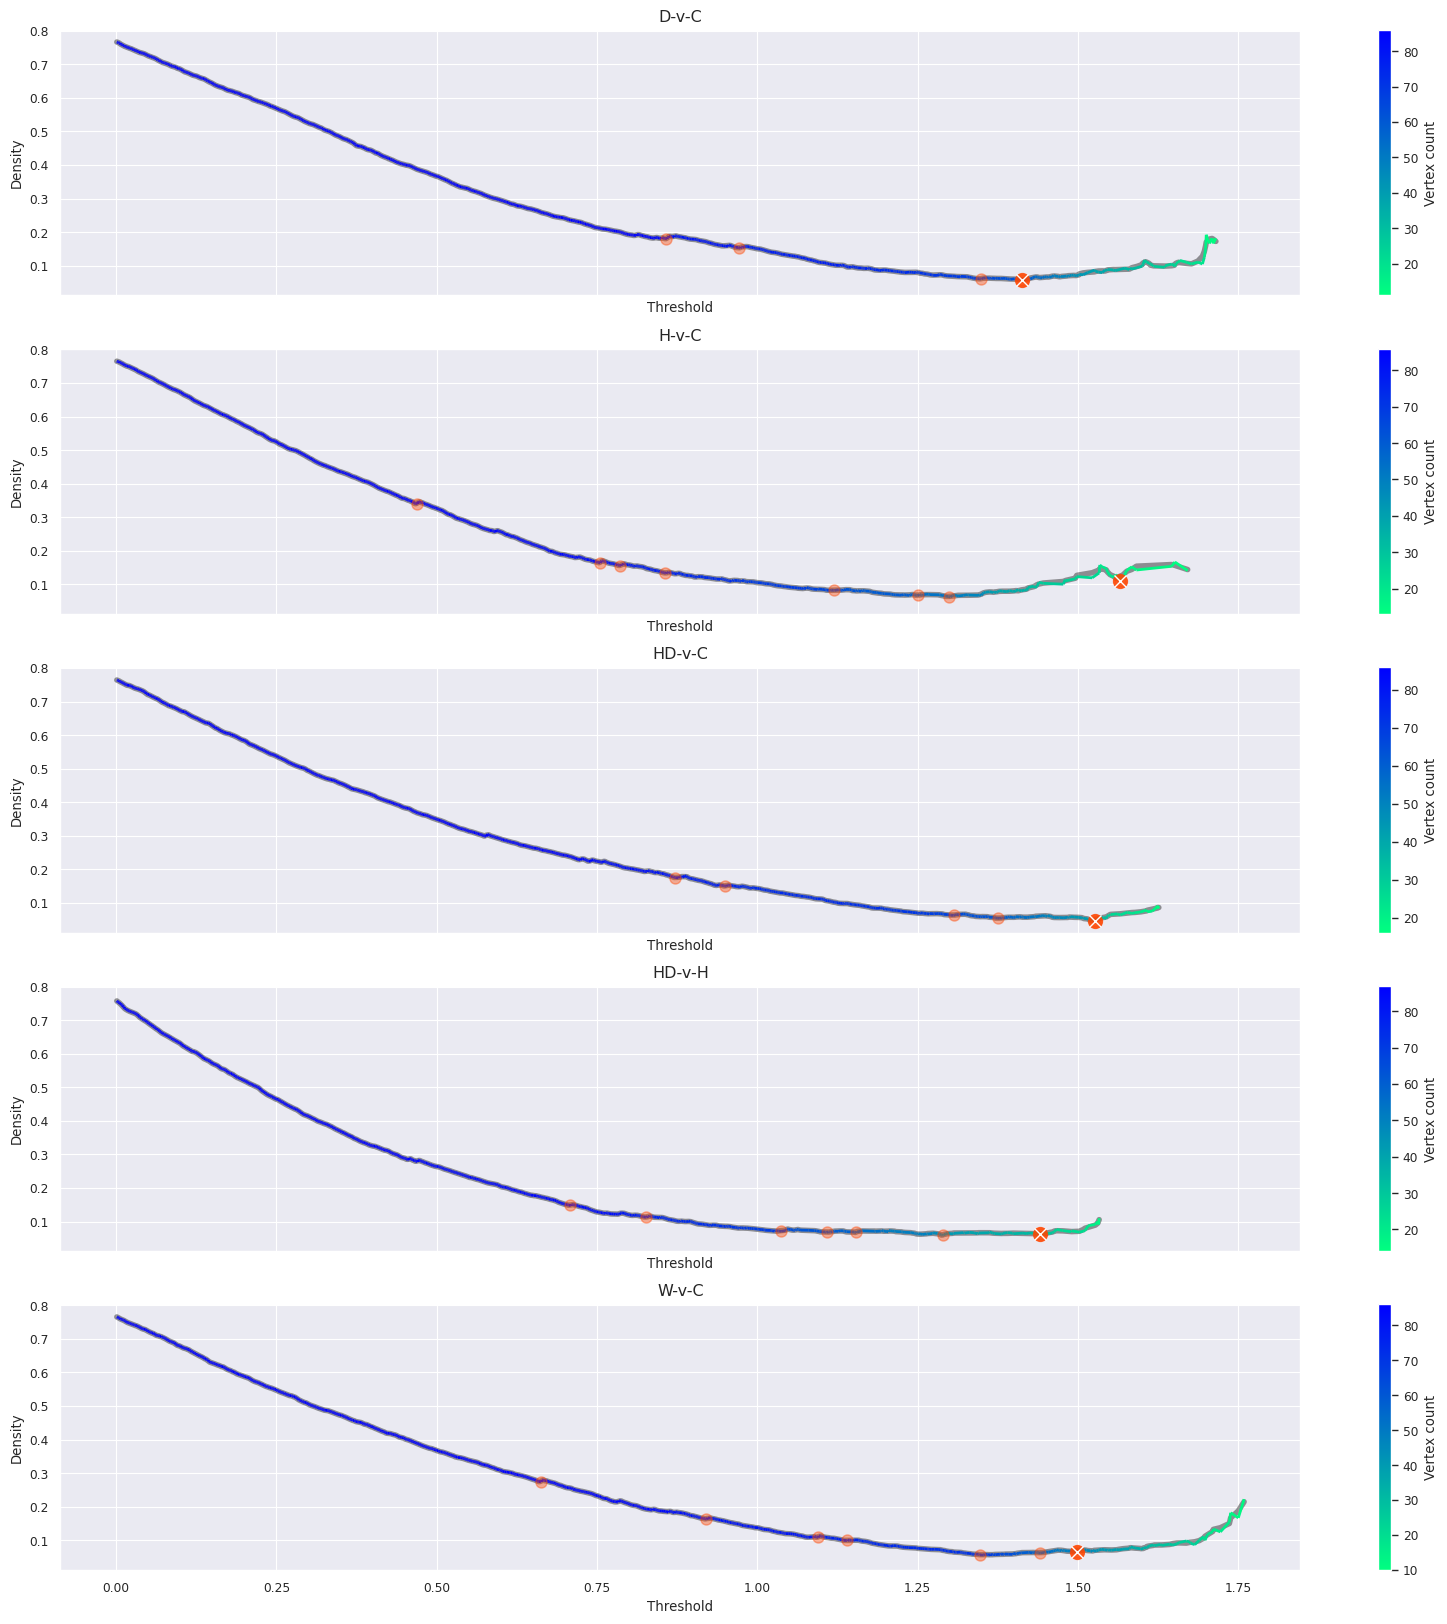

In [11]:
plot_and_calculate_thresholds(max_v=100, minima_order=3, smoothing_window=10)

# Thresholds

In [12]:
thresholds_df = pd.DataFrame.from_dict(thresholds, orient='index')
thresholds_df.columns = ["density-minima"]
thresholds_df.index.names = ["contrast"]

In [13]:
style = thresholds_df.style.background_gradient(cmap='Greens',                                                 vmax=thresholds_df.max().max(), vmin=thresholds_df.min().min(), axis=None)
style = style.format('{:.2f}')
style

,density-minima
contrast,
D-v-C,1.41
H-v-C,1.56
HD-v-C,1.53
HD-v-H,1.44
W-v-C,1.50


In [14]:
thresholds_df.to_csv(base_dir / "output" / "thresholds.tsv", sep="\t")

# END